In [1]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
from textblob import TextBlob
nltk.download('vader_lexicon')
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\i_sar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
def analyze_sentiments(input_csv, output_csv):
    # Read the input CSV file
    data = pd.read_csv(input_csv)

    # Ensure all entries in the 'headline' column are strings and fill NaNs with empty string
    data['headline'] = data['headline'].fillna('').astype(str)

    # Initialize the sentiment intensity analyzer
    sid = SentimentIntensityAnalyzer()

    # Initialize a list to hold sentiment scores
    sentiment_scores_list = []

    # Iterate over rows in the DataFrame
    for index, row in data.iterrows():
        text = row['headline']
        sentiment_scores = sid.polarity_scores(text)
        sentiment_scores_list.append(sentiment_scores)

    # Convert the list of sentiment scores to a DataFrame
    sentiment_scores_df = pd.DataFrame(sentiment_scores_list)

    # Concatenate the original DataFrame with the sentiment scores DataFrame
    result_df = pd.concat([data, sentiment_scores_df], axis=1)

    # Write the updated DataFrame to the output CSV file
    result_df.to_csv(output_csv, index=False, encoding='utf-8')

In [3]:
def subjective(text):
    return TextBlob(text).sentiment.subjectivity
def polar(text):
    return TextBlob(text).sentiment.subjectivity

In [4]:
def download_yfinance_data(ticker, start_date, end_date, output_csv):
    # Download the data
    data = yf.download(ticker, start=start_date, end=end_date)

    # Reset the index to get 'Date' as a column
    data.reset_index(inplace=True)

    # Save the data to a CSV file
    data.to_csv(output_csv, index=False, encoding='utf-8')

In [5]:
input_csv = 'final_headlines_weekday.csv'
output_csv = 'sentiment_nytimes_headlines.csv'
analyze_sentiments(input_csv, output_csv)

print(f"Sentiment analysis results have been saved to {output_csv}")

Sentiment analysis results have been saved to sentiment_nytimes_headlines.csv


In [6]:
raw_data= pd.read_csv('final_headlines_weekday.csv')
raw_data

,date,headline
0,2018-01-01,Top News Kim Jong-un Offers North Korea’s Hand...
1,2018-01-02,"Top News The Trump Effect: Business, Anticipat..."
2,2018-01-03,Top News Hard-Liners and Reformers Tapped Iran...
3,2018-01-04,Top News Obstruction Inquiry Shows Trump’s Str...
4,2018-01-05,Top News Obstruction Inquiry Shows Trump’s Str...
...,...,...
1300,2022-12-27,Top News George Santos Admits to Lying About C...
1301,2022-12-28,Top News ‘Tragic Battle’: On the Front Lines o...
1302,2022-12-29,Top News U.S. Scrambles to Stop Iran From Prov...
1303,2022-12-30,Top News Russian Missile Barrage Staggers Ukra...


In [7]:
data_sentiment=pd.read_csv('sentiment_nytimes_headlines.csv')
data_sentiment

,date,headline,neg,neu,pos,compound
0,2018-01-01,Top News Kim Jong-un Offers North Korea’s Hand...,0.118,0.802,0.080,-0.7808
1,2018-01-02,"Top News The Trump Effect: Business, Anticipat...",0.093,0.832,0.075,-0.2869
2,2018-01-03,Top News Hard-Liners and Reformers Tapped Iran...,0.130,0.791,0.079,-0.8446
3,2018-01-04,Top News Obstruction Inquiry Shows Trump’s Str...,0.133,0.743,0.124,-0.6705
4,2018-01-05,Top News Obstruction Inquiry Shows Trump’s Str...,0.133,0.743,0.124,-0.6705
...,...,...,...,...,...,...
1300,2022-12-27,Top News George Santos Admits to Lying About C...,0.128,0.783,0.089,-0.8587
1301,2022-12-28,Top News ‘Tragic Battle’: On the Front Lines o...,0.131,0.746,0.123,-0.6775
1302,2022-12-29,Top News U.S. Scrambles to Stop Iran From Prov...,0.174,0.753,0.073,-0.9601
1303,2022-12-30,Top News Russian Missile Barrage Staggers Ukra...,0.099,0.847,0.054,-0.8355


In [8]:


ticker = 'NVDA'  # You can change this to any ticker symbol you need
start_date = '2018-01-01'
end_date = '2022-12-31'
output_csv = 'yfinance_data.csv'

download_yfinance_data(ticker, start_date, end_date, output_csv)

print(f"Data for {ticker} has been downloaded and saved to {output_csv}")


[*********************100%%**********************]  1 of 1 completed

Data for NVDA has been downloaded and saved to yfinance_data.csv


In [9]:
def align_with_yfinance(sentiment_csv, yfinance_csv, output_csv):
    # Read the sentiment CSV file into a DataFrame
    sentiment_data = pd.read_csv(sentiment_csv, parse_dates=['date'])

    # Read the yfinance CSV file into a DataFrame
    yfinance_data = pd.read_csv(yfinance_csv, parse_dates=['Date'])

    # Ensure the date columns are in datetime format
    sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])
    yfinance_data['Date'] = pd.to_datetime(yfinance_data['Date'])

    # Get the unique dates from the yfinance data
    yfinance_dates = yfinance_data['Date'].unique()

    # Filter the sentiment data to only include rows with dates in the yfinance data
    filtered_sentiment_data = sentiment_data[sentiment_data['date'].isin(yfinance_dates)]

    # Write the filtered sentiment data to the output CSV file
    filtered_sentiment_data.to_csv(output_csv, index=False, encoding='utf-8')

# Example usage


In [10]:
sentiment_csv = 'sentiment_nytimes_headlines.csv'
yfinance_csv = 'yfinance_data.csv'
output_csv = 'sentiment_nytimes_headlines.csv'
align_with_yfinance(sentiment_csv, yfinance_csv, output_csv)

print(f"Sentiment data has been aligned with yfinance dates and saved to {output_csv}")

Sentiment data has been aligned with yfinance dates and saved to sentiment_nytimes_headlines.csv


In [11]:
data_sentiment=pd.read_csv('sentiment_nytimes_headlines.csv')
data_sentiment.rename(columns={'date': 'Date'}, inplace=True)
yf_data= pd.read_csv('yfinance_data.csv')

In [12]:
data_final=pd.merge(data_sentiment,yf_data,on='Date')

In [13]:
data_final

,Date,headline,neg,neu,pos,compound,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,"Top News The Trump Effect: Business, Anticipat...",0.093,0.832,0.075,-0.2869,4.89450,4.98750,4.86250,4.98375,4.930643,355616000
1,2018-01-03,Top News Hard-Liners and Reformers Tapped Iran...,0.130,0.791,0.079,-0.8446,5.10250,5.34250,5.09375,5.31175,5.255148,914704000
2,2018-01-04,Top News Obstruction Inquiry Shows Trump’s Str...,0.133,0.743,0.124,-0.6705,5.39400,5.45125,5.31725,5.33975,5.282848,583268000
3,2018-01-05,Top News Obstruction Inquiry Shows Trump’s Str...,0.133,0.743,0.124,-0.6705,5.35475,5.42275,5.27700,5.38500,5.327617,580124000
4,2018-01-08,Top News Kushner’s Financial Ties to Israel De...,0.095,0.786,0.120,0.9784,5.51000,5.62500,5.46450,5.55000,5.490859,881216000
...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2022-12-23,Top News Winter Storm Raises Fears and Scrambl...,0.087,0.812,0.101,0.8896,15.19600,15.33900,14.88300,15.20600,15.197294,349326000
1254,2022-12-27,Top News George Santos Admits to Lying About C...,0.128,0.783,0.089,-0.8587,15.07400,15.10000,14.05600,14.12100,14.112917,464902000
1255,2022-12-28,Top News ‘Tragic Battle’: On the Front Lines o...,0.131,0.746,0.123,-0.6775,13.92700,14.26200,13.88400,14.03600,14.027965,351066000
1256,2022-12-29,Top News U.S. Scrambles to Stop Iran From Prov...,0.174,0.753,0.073,-0.9601,14.40200,14.68300,14.22700,14.60300,14.594639,354923000


In [14]:
data_final['Signal'] = (data_final['Close'].shift(-1) > data_final['Close']).astype(int)

In [15]:
data_final

,Date,headline,neg,neu,pos,compound,Open,High,Low,Close,Adj Close,Volume,Signal
0,2018-01-02,"Top News The Trump Effect: Business, Anticipat...",0.093,0.832,0.075,-0.2869,4.89450,4.98750,4.86250,4.98375,4.930643,355616000,1
1,2018-01-03,Top News Hard-Liners and Reformers Tapped Iran...,0.130,0.791,0.079,-0.8446,5.10250,5.34250,5.09375,5.31175,5.255148,914704000,1
2,2018-01-04,Top News Obstruction Inquiry Shows Trump’s Str...,0.133,0.743,0.124,-0.6705,5.39400,5.45125,5.31725,5.33975,5.282848,583268000,1
3,2018-01-05,Top News Obstruction Inquiry Shows Trump’s Str...,0.133,0.743,0.124,-0.6705,5.35475,5.42275,5.27700,5.38500,5.327617,580124000,1
4,2018-01-08,Top News Kushner’s Financial Ties to Israel De...,0.095,0.786,0.120,0.9784,5.51000,5.62500,5.46450,5.55000,5.490859,881216000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2022-12-23,Top News Winter Storm Raises Fears and Scrambl...,0.087,0.812,0.101,0.8896,15.19600,15.33900,14.88300,15.20600,15.197294,349326000,0
1254,2022-12-27,Top News George Santos Admits to Lying About C...,0.128,0.783,0.089,-0.8587,15.07400,15.10000,14.05600,14.12100,14.112917,464902000,0
1255,2022-12-28,Top News ‘Tragic Battle’: On the Front Lines o...,0.131,0.746,0.123,-0.6775,13.92700,14.26200,13.88400,14.03600,14.027965,351066000,1
1256,2022-12-29,Top News U.S. Scrambles to Stop Iran From Prov...,0.174,0.753,0.073,-0.9601,14.40200,14.68300,14.22700,14.60300,14.594639,354923000,1


In [16]:
data_final['subjectivity']= data_final['headline'].apply(subjective)
data_final['polarity']= data_final['headline'].apply(polar)

In [17]:
data_final['positions'] = data_final['Signal'].diff()
data_final= data_final[1:]
data_final= data_final.drop(columns=['headline'])
data_final


,Date,neg,neu,pos,compound,Open,High,Low,Close,Adj Close,Volume,Signal,subjectivity,polarity,positions
1,2018-01-03,0.130,0.791,0.079,-0.8446,5.10250,5.34250,5.09375,5.31175,5.255148,914704000,1,0.542100,0.542100,0.0
2,2018-01-04,0.133,0.743,0.124,-0.6705,5.39400,5.45125,5.31725,5.33975,5.282848,583268000,1,0.342577,0.342577,0.0
3,2018-01-05,0.133,0.743,0.124,-0.6705,5.35475,5.42275,5.27700,5.38500,5.327617,580124000,1,0.342577,0.342577,0.0
4,2018-01-08,0.095,0.786,0.120,0.9784,5.51000,5.62500,5.46450,5.55000,5.490859,881216000,0,0.371787,0.371787,-1.0
5,2018-01-09,0.133,0.746,0.121,0.2617,5.55550,5.59550,5.46600,5.54850,5.489375,497000000,1,0.645370,0.645370,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2022-12-23,0.087,0.812,0.101,0.8896,15.19600,15.33900,14.88300,15.20600,15.197294,349326000,0,0.667388,0.667388,0.0
1254,2022-12-27,0.128,0.783,0.089,-0.8587,15.07400,15.10000,14.05600,14.12100,14.112917,464902000,0,0.328070,0.328070,0.0
1255,2022-12-28,0.131,0.746,0.123,-0.6775,13.92700,14.26200,13.88400,14.03600,14.027965,351066000,1,0.450036,0.450036,1.0
1256,2022-12-29,0.174,0.753,0.073,-0.9601,14.40200,14.68300,14.22700,14.60300,14.594639,354923000,1,0.496212,0.496212,0.0


In [18]:
X = data_final.drop(columns=['Signal', 'Date','positions'])
y = data_final['Signal'] 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
    
# Train the logistic regression model
modellog = LogisticRegression(max_iter=1000)
modellog.fit(X_train, y_train)
    
# Make predictions
y_pred_logistic = modellog.predict(X_test)

In [21]:
print(classification_report(y_test,y_pred_logistic))

              precision    recall  f1-score   support

           0       0.51      0.27      0.35       119
           1       0.54      0.77      0.63       133

    accuracy                           0.53       252
   macro avg       0.52      0.52      0.49       252
weighted avg       0.52      0.53      0.50       252



In [22]:
y_probs = modellog.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class


In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

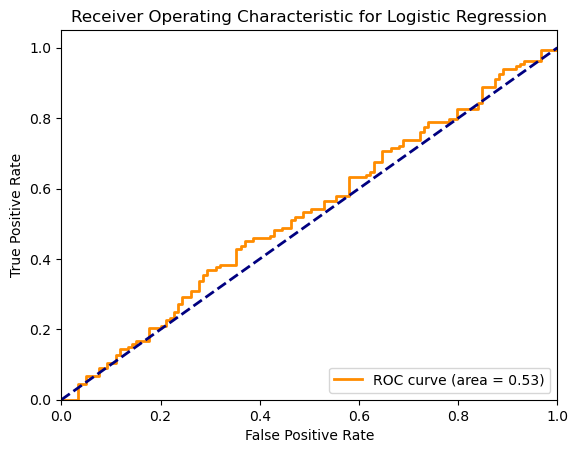

In [24]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [25]:
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [26]:
y_pred_randomforest = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_randomforest)
print(f'Accuracy: {accuracy:.2f}')
# Generate classification report
class_report = classification_report(y_test, y_pred_randomforest)
print('Classification Report:')
print(class_report)

Accuracy: 0.48
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.42      0.43       119
           1       0.50      0.53      0.51       133

    accuracy                           0.48       252
   macro avg       0.47      0.47      0.47       252
weighted avg       0.47      0.48      0.48       252



In [27]:
y_probs = clf.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

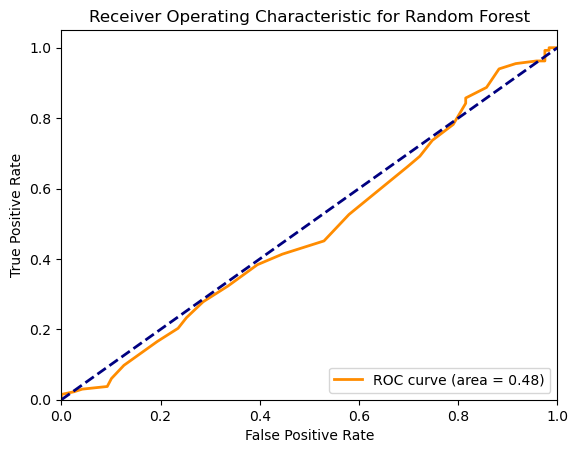

In [28]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest')
plt.legend(loc="lower right")
plt.show()

In [29]:
 modelnn = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

    # Compile the model with a lower learning rate
modelnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
modelnn.fit(X_train, y_train, epochs=100, batch_size=20, validation_split=0.2)

# Make predictions
y_pred_prob = modelnn.predict(X_test).flatten()
y_prednn = (y_pred_prob > 0.5).astype(int)

    # Print the classification report
print(classification_report(y_test, y_prednn))

Epoch 1/100


C:\Users\i_sar\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4727 - loss: 0.8538 - val_accuracy: 0.5124 - val_loss: 0.7576
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5105 - loss: 0.7895 - val_accuracy: 0.5423 - val_loss: 0.7498
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5340 - loss: 0.7780 - val_accuracy: 0.5423 - val_loss: 0.7472
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5053 - loss: 0.7922 - val_accuracy: 0.5323 - val_loss: 0.7477
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5124 - loss: 0.7725 - val_accuracy: 0.5522 - val_loss: 0.7438
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5244 - loss: 0.7705 - val_accuracy: 0.5423 - val_loss: 0.7429
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5145 - loss: 0.7640 - val_accuracy: 0.5423 - val_loss: 0.7426
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4994 - loss: 0.7628 - val_accuracy: 0.5323 - val_loss: 0.7

In [30]:
y_probs = clf.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

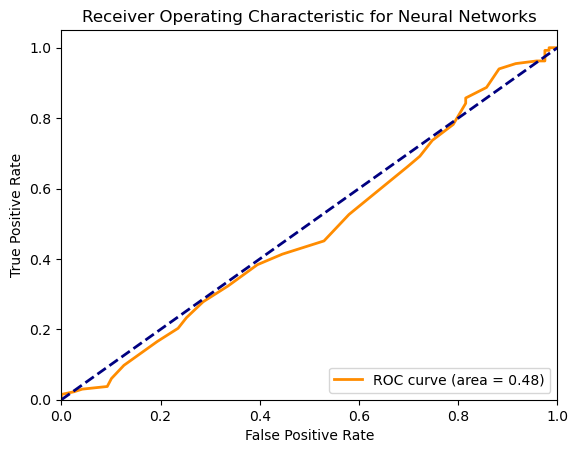

In [31]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Neural Networks')
plt.legend(loc="lower right")
plt.show()

In [32]:
svm_model = SVC(kernel='poly')  
svm_model.fit(X_train, y_train)

SVC(kernel='poly')

In [33]:
y_predsvm = svm_model.predict(X_test)


In [34]:
accuracy = accuracy_score(y_test, y_predsvm)
print(f'Accuracy: {accuracy}')

print('Classification Report:')
print(classification_report(y_test, y_predsvm))

Accuracy: 0.5277777777777778
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.10      0.17       119
           1       0.53      0.91      0.67       133

    accuracy                           0.53       252
   macro avg       0.52      0.51      0.42       252
weighted avg       0.52      0.53      0.43       252



In [35]:
svm_model = SVC(kernel='poly', probability=True)  # Enable probability estimates
svm_model.fit(X_train, y_train)

SVC(kernel='poly', probability=True)

In [36]:
y_probs = svm_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class


In [37]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

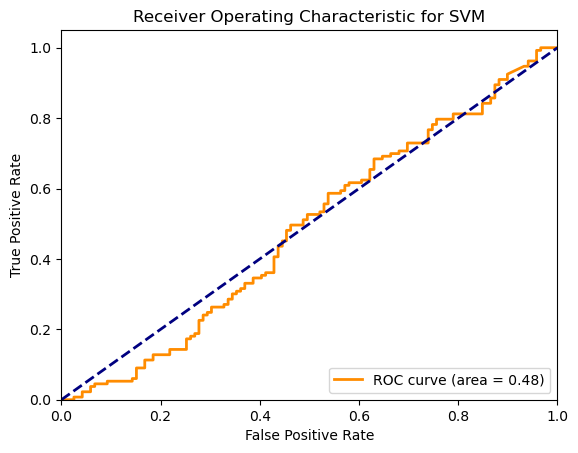

In [38]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for SVM')
plt.legend(loc="lower right")
plt.show()

In [39]:
data_testing= data_final[-251:]

In [40]:
data_testing["y_indi_rf"]=y_pred_randomforest[1:]
data_testing['y_indi_nn']=y_prednn[1:]
data_testing['y_indi_log']=y_pred_logistic[1:]
data_testing['y_indi_svm']=y_predsvm[1:]

C:\Users\i_sar\AppData\Local\Temp\ipykernel_20556\3000930425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_testing["y_indi_rf"]=y_pred_randomforest[1:]
C:\Users\i_sar\AppData\Local\Temp\ipykernel_20556\3000930425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_testing['y_indi_nn']=y_prednn[1:]
C:\Users\i_sar\AppData\Local\Temp\ipykernel_20556\3000930425.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [41]:
data_testing

,Date,neg,neu,pos,compound,Open,High,Low,Close,Adj Close,Volume,Signal,subjectivity,polarity,positions,y_indi_rf,y_indi_nn,y_indi_log,y_indi_svm
1007,2021-12-31,0.078,0.854,0.067,-0.1521,29.674000,30.030001,29.330999,29.410999,29.366703,266530000,1,0.294120,0.294120,1.0,0,0,1,1
1008,2022-01-03,0.129,0.807,0.064,-0.9956,29.815001,30.711000,29.785000,30.121000,30.075634,391547000,0,0.407446,0.407446,-1.0,1,1,1,1
1009,2022-01-04,0.132,0.798,0.071,-0.9413,30.277000,30.468000,28.349001,29.290001,29.245884,527154000,0,0.441707,0.441707,0.0,0,0,1,1
1010,2022-01-05,0.148,0.806,0.046,-0.9797,28.948999,29.416000,27.533001,27.604000,27.562424,498064000,1,0.366481,0.366481,1.0,0,0,0,0
1011,2022-01-06,0.197,0.764,0.039,-0.9876,27.639999,28.438000,27.065001,28.177999,28.135559,454186000,0,0.562563,0.562563,-1.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2022-12-23,0.087,0.812,0.101,0.8896,15.196000,15.339000,14.883000,15.206000,15.197294,349326000,0,0.667388,0.667388,0.0,1,0,1,1
1254,2022-12-27,0.128,0.783,0.089,-0.8587,15.074000,15.100000,14.056000,14.121000,14.112917,464902000,0,0.328070,0.328070,0.0,0,1,1,1
1255,2022-12-28,0.131,0.746,0.123,-0.6775,13.927000,14.262000,13.884000,14.036000,14.027965,351066000,1,0.450036,0.450036,1.0,1,1,1,1
1256,2022-12-29,0.174,0.753,0.073,-0.9601,14.402000,14.683000,14.227000,14.603000,14.594639,354923000,1,0.496212,0.496212,0.0,0,1,1,1


In [42]:

def simulate_trading(df, indicator_column, initial_capital=10000, stop_loss_pct=0.05):

    position_open = False
    position_price = 0
    n_shares = 0
    capital = initial_capital  # Initial capital
    investment_log = []

    # Generate signals based on the indicator
    df['Signal'] = df[indicator_column].apply(lambda x: 1 if x > 0 else 0)

    # Iterate over the data to simulate trading
    for i in range(len(df)):
        # Check for buy signal
        if df.iloc[i]['Signal'] == 1 and not position_open:
            n_shares = capital / df.iloc[i]['Close']
            position_open = True
            position_price = df.iloc[i]['Close']
            investment_log.append(('Buy', df.iloc[i]['Date'], n_shares, position_price))

        # Check for sell signal or stop loss
        elif position_open:
            if df.iloc[i]['Signal'] == 0 or df.iloc[i]['Close'] <= position_price * (1 - stop_loss_pct):
                capital = n_shares * df.iloc[i]['Close']
                position_open = False
                investment_log.append(('Sell', df.iloc[i]['Date'], n_shares, df.iloc[i]['Close']))

    # Calculate final profit/loss if still holding shares
    if position_open:
        capital = n_shares * df.iloc[-1]['Close']
        investment_log.append(('Sell', df.iloc[-1]['Date'], n_shares, df.iloc[-1]['Close']))

    print(f"Final capital: {capital:.2f}")
    print("Investment log:")
    for log in investment_log:
        print(log)

    # Plotting the data for visualization
    plt.figure(figsize=(12, 8))
    plt.plot(df['Date'], df['Close'], label='Close Price', color='black')
    plt.plot(df['Date'], df['Signal'], label='Trading Signals', color='blue')

    # Mark buy and sell points
    for log in investment_log:
        if log[0] == 'Buy':
            plt.scatter(log[1], log[3], marker='^', color='green', label='Buy Signal', alpha=1)
        else:
            plt.scatter(log[1], log[3], marker='v', color='red', label='Sell Signal', alpha=1)

    plt.title('Trading Strategy Simulation')
    plt.xlabel('Date')
    plt.ylabel('Price/Signal')
    plt.show()

    return capital


C:\Users\i_sar\AppData\Local\Temp\ipykernel_20556\1981375708.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = df[indicator_column].apply(lambda x: 1 if x > 0 else 0)


Final capital: 11782.75
Investment log:
('Buy', '2021-12-31', 340.0088483442818, 29.410999298095703)
('Sell', '2022-01-05', 340.0088483442818, 27.60400009155273)
('Buy', '2022-01-06', 333.0827045405909, 28.17799949645996)
('Sell', '2022-01-11', 333.0827045405909, 27.816999435424805)
('Buy', '2022-01-13', 348.6495254245308, 26.575000762939453)
('Sell', '2022-01-14', 348.6495254245308, 26.941999435424805)
('Buy', '2022-01-18', 362.6342648116323, 25.902999877929688)
('Sell', '2022-01-19', 362.6342648116323, 25.066999435424805)
('Buy', '2022-01-21', 388.90017530887434, 23.374000549316406)
('Sell', '2022-01-24', 388.90017530887434, 23.371999740600582)
('Buy', '2022-01-26', 399.1469810398523, 22.77199935913086)
('Sell', '2022-01-28', 399.1469810398523, 22.84000015258789)
('Buy', '2022-01-31', 372.3154898771088, 24.48600006103516)
('Sell', '2022-02-03', 372.3154898771088, 23.947999954223636)
('Buy', '2022-02-04', 366.6356036441921, 24.319000244140625)
('Sell', '2022-02-09', 366.6356036441921,

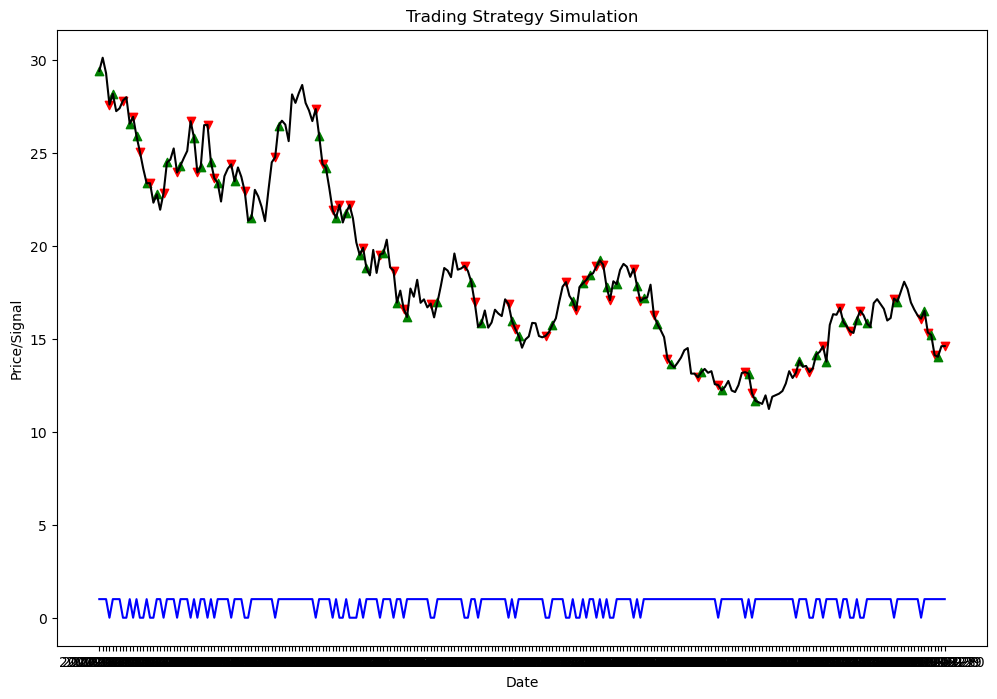

11782.74644345856

In [43]:
simulate_trading(data_testing,"y_indi_log")

C:\Users\i_sar\AppData\Local\Temp\ipykernel_20556\1981375708.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = df[indicator_column].apply(lambda x: 1 if x > 0 else 0)


Final capital: 5504.79
Investment log:
('Buy', '2022-01-03', 331.9942865027461, 30.121000289916992)
('Sell', '2022-01-04', 331.9942865027461, 29.290000915527344)
('Buy', '2022-01-07', 356.88747561902903, 27.246999740600582)
('Sell', '2022-01-10', 356.88747561902903, 27.399999618530277)
('Buy', '2022-01-11', 351.53743733288803, 27.816999435424805)
('Sell', '2022-01-13', 351.53743733288803, 26.575000762939453)
('Buy', '2022-01-19', 372.685517841476, 25.066999435424805)
('Sell', '2022-01-20', 372.685517841476, 24.149999618530277)
('Buy', '2022-01-21', 385.0583940354459, 23.374000549316406)
('Sell', '2022-01-24', 385.0583940354459, 23.371999740600582)
('Buy', '2022-01-25', 403.1349635108055, 22.323999404907227)
('Sell', '2022-01-28', 403.1349635108055, 22.84000015258789)
('Buy', '2022-01-31', 376.03539186265346, 24.48600006103516)
('Sell', '2022-02-10', 376.03539186265346, 25.823999404907227)
('Buy', '2022-02-11', 405.47571827553924, 23.948999404907227)
('Sell', '2022-02-22', 405.475718275

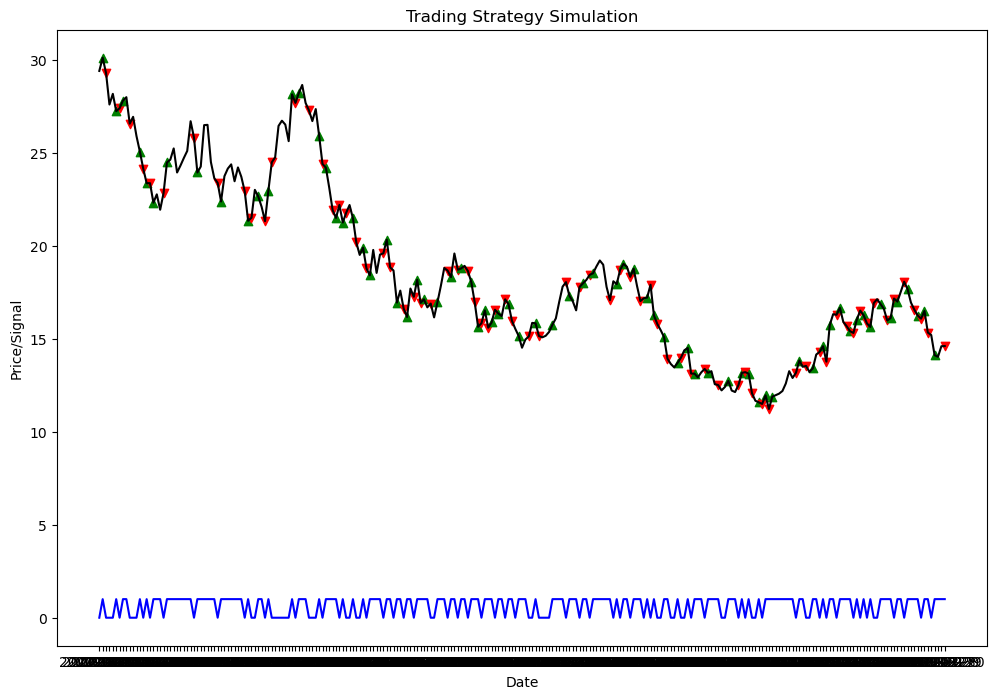

5504.790440562691

In [56]:
simulate_trading(data_testing,"y_indi_nn")

C:\Users\i_sar\AppData\Local\Temp\ipykernel_20556\1981375708.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = df[indicator_column].apply(lambda x: 1 if x > 0 else 0)


Final capital: 5059.59
Investment log:
('Buy', '2021-12-31', 340.0088483442818, 29.410999298095703)
('Sell', '2022-01-05', 340.0088483442818, 27.60400009155273)
('Buy', '2022-01-10', 342.5403069887974, 27.399999618530277)
('Sell', '2022-01-18', 342.5403069887974, 25.902999877929688)
('Buy', '2022-01-19', 353.9642450215921, 25.066999435424805)
('Sell', '2022-01-21', 353.9642450215921, 23.374000549316406)
('Buy', '2022-01-26', 363.32165336442546, 22.77199935913086)
('Sell', '2022-01-28', 363.32165336442546, 22.84000015258789)
('Buy', '2022-01-31', 338.89841532292917, 24.48600006103516)
('Sell', '2022-02-23', 338.89841532292917, 22.386999130249023)
('Buy', '2022-02-24', 319.47611535466467, 23.74799919128418)
('Sell', '2022-03-04', 319.47611535466467, 22.93600082397461)
('Buy', '2022-03-07', 343.1765029565528, 21.351999282836918)
('Sell', '2022-03-08', 343.1765029565528, 21.513999938964844)
('Buy', '2022-03-09', 320.80904159390263, 23.013999938964844)
('Sell', '2022-03-14', 320.80904159390

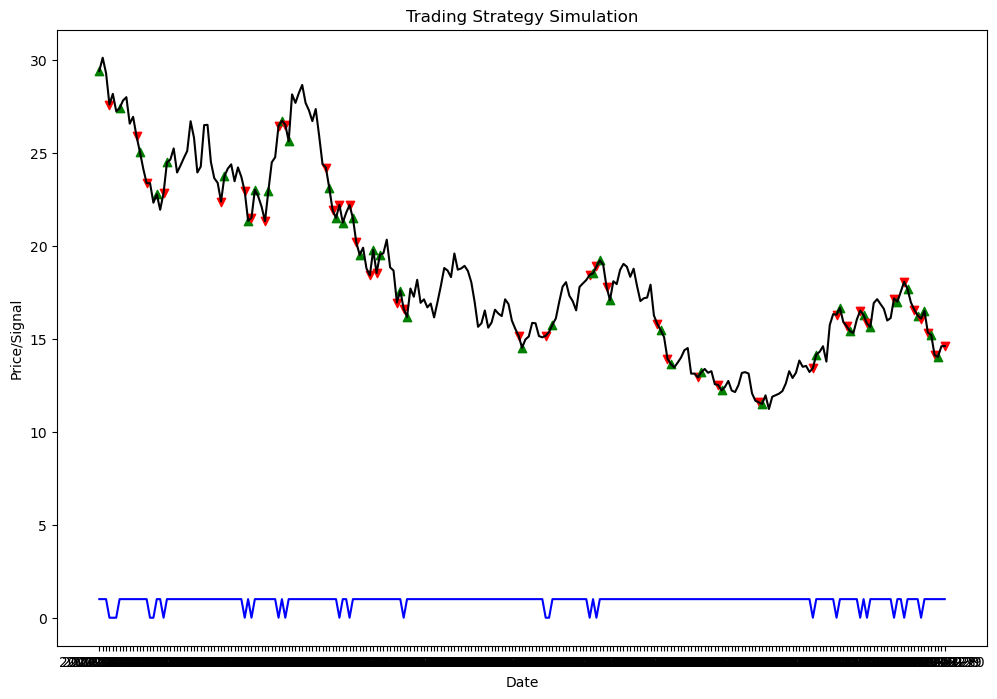

5059.589388659208

In [57]:
simulate_trading(data_testing,"y_indi_svm")

C:\Users\i_sar\AppData\Local\Temp\ipykernel_20556\1981375708.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = df[indicator_column].apply(lambda x: 1 if x > 0 else 0)


Final capital: 10892.57
Investment log:
('Buy', '2022-01-03', 331.9942865027461, 30.121000289916992)
('Sell', '2022-01-04', 331.9942865027461, 29.290000915527344)
('Buy', '2022-01-12', 347.3021452493487, 27.999000549316406)
('Sell', '2022-01-13', 347.3021452493487, 26.575000762939453)
('Buy', '2022-01-18', 356.3121962115234, 25.902999877929688)
('Sell', '2022-01-19', 356.3121962115234, 25.066999435424805)
('Buy', '2022-01-26', 392.2219336304305, 22.77199935913086)
('Sell', '2022-01-27', 392.2219336304305, 21.944000244140625)
('Buy', '2022-01-31', 351.5036423217101, 24.48600006103516)
('Sell', '2022-02-01', 351.5036423217101, 24.63800048828125)
('Buy', '2022-02-02', 343.092730854057, 25.242000579833984)
('Sell', '2022-02-03', 343.092730854057, 23.947999954223636)
('Buy', '2022-02-04', 337.85865456237497, 24.319000244140625)
('Sell', '2022-02-07', 337.85865456237497, 24.72800064086914)
('Buy', '2022-02-08', 332.7453039886239, 25.107999801635746)
('Sell', '2022-02-09', 332.7453039886239, 

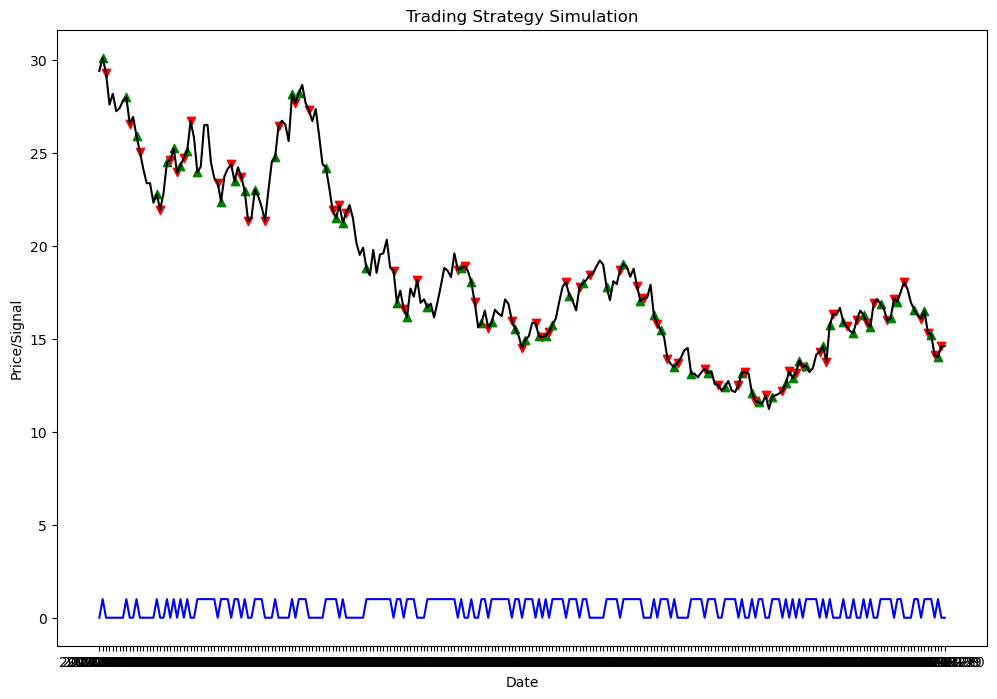

10892.57164480337

In [58]:
simulate_trading(data_testing,"y_indi_rf")

In [51]:
def calculate_metrics(df, position_col):
    # Identify buy (when position changes from 0 to 1) and sell (when position changes from 1 to 0) signals
    df[f'signal{position_col}'] = df[position_col].diff()
    
    # Identify buy and sell points
    buy_points = df[df[f'signal{position_col}'] == 1].index
    sell_points = df[df[f'signal{position_col}'] == -1].index

    # Ensure there is a corresponding sell for every buy
    if sell_points[0] < buy_points[0]:
        sell_points = sell_points[1:]
    if len(buy_points) > len(sell_points):
        buy_points = buy_points[:-1]
    
    trades = pd.DataFrame({
        'buy': buy_points,
        'sell': sell_points
    })
    trades[f'buy_price{position_col}'] = df.loc[trades['buy'], 'Close'].values
    trades[f'sell_price{position_col}'] = df.loc[trades['sell'], 'Close'].values
    trades[f'returns{position_col}'] = (trades[f'sell_price{position_col}'] - trades[f'buy_price{position_col}']) / trades[f'buy_price{position_col}']
    
    # Sharpe ratio
    daily_returns = trades[f'returns{position_col}'].pct_change().dropna()
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)  # Annualized
    
    # Maximum drawdown
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # Number of trades executed
    num_trades = len(trades)
    
    # Win ratio
    win_ratio = len(trades[trades[f'returns{position_col}'] > 0]) / num_trades
    
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Number of Trades': num_trades,
        'Win Ratio': win_ratio
    }

    

In [52]:
calculate_metrics(data_testing,"y_indi_log")

C:\Users\i_sar\AppData\Local\Temp\ipykernel_20556\1891409549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'signal{position_col}'] = df[position_col].diff()


{'Sharpe Ratio': 1.8540120535348972,
 'Max Drawdown': -4.039962456461723,
 'Number of Trades': 46,
 'Win Ratio': 0.5434782608695652}

In [53]:
calculate_metrics(data_testing,"y_indi_rf")

C:\Users\i_sar\AppData\Local\Temp\ipykernel_20556\1891409549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'signal{position_col}'] = df[position_col].diff()


{'Sharpe Ratio': -6.985198270805805,
 'Max Drawdown': -2.7526243431088515,
 'Number of Trades': 60,
 'Win Ratio': 0.5333333333333333}

In [54]:
calculate_metrics(data_testing,"y_indi_nn")

C:\Users\i_sar\AppData\Local\Temp\ipykernel_20556\1891409549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'signal{position_col}'] = df[position_col].diff()


{'Sharpe Ratio': -2.5954667674922263,
 'Max Drawdown': -2.2238472160603835,
 'Number of Trades': 64,
 'Win Ratio': 0.4375}

In [55]:
calculate_metrics(data_testing,"y_indi_svm")

C:\Users\i_sar\AppData\Local\Temp\ipykernel_20556\1891409549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'signal{position_col}'] = df[position_col].diff()


{'Sharpe Ratio': -2.736284003796698,
 'Max Drawdown': -3.3606213246313765,
 'Number of Trades': 19,
 'Win Ratio': 0.47368421052631576}